# Recommender system for La Fourchette

We try in this notebook to implement a recommender system for the mobile app La Fourchette. La Fourchette allows its users to find restaurant near their position and to reserve easily a table. The users are able to evaluate their experience. A user can give several grades. For example "cooking", "surroudings", "service". 
It is also possible to consider some metadata such as the hour, and the distance. 

The first thing we need is data. We will generate random users and items. There are several ways to do this:
- We can chose users, items and metadata uniformly
- Or we can define several clusters and chose random users/items/metadata in these clusters

In [470]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as mplt

from user import *
from restaurant import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
n_users = 1000
n_items = 500

In [4]:
metadata = ["weather", "hour", "distance", "last_time_visited", "last_visited"]
items=[]
ratings = np.zeros((n_users, n_items, 3))

In [72]:
restaurants = Restaurant.load_from_csv("./data/restaurants.csv", set_random_params=True)

In [384]:
import pandas 
df = pandas.read_csv("./data/restaurants.csv")

In [707]:
a = list(df["speciality"])

In [720]:
"E".lower()

'e'

In [724]:
a = np.concatenate([sp.split(";,") for sp in a])

In [725]:
a = [sp.lower().replace(" ", "").replace("_", "") for sp in a]

In [727]:
b = np.unique(a)

In [728]:
len(b)

292

(array([88., 26., 17.,  8.,  9., 13., 14., 16., 19., 82.]),
 array([2.49160505e-08, 1.00000022e-01, 2.00000019e-01, 3.00000016e-01,
        4.00000013e-01, 5.00000010e-01, 6.00000007e-01, 7.00000004e-01,
        8.00000001e-01, 8.99999998e-01, 9.99999995e-01]),
 <a list of 10 Patch objects>)

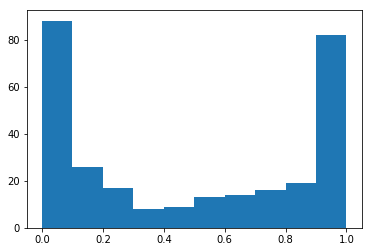

In [740]:
mplt.hist(np.random.beta(0.3,0.3, 292), bins=10)

In [385]:
np.unique(df["speciality"])

array(['African', 'Américaine;sandwiches', 'Auvergne', 'Bar à vins',
       'Bistrot_gastronome', 'Brasserie', 'Brasserie,_Pub', 'Cap Vert',
       'Cap_Vert', 'Chinese; Sichuan', 'Chinese;Shanxi',
       'Chinese;Sichuan', 'Chinese;Sichuan;vietnamese', 'Chinese;火鍋',
       'Congo', 'Franco_Portugaise', 'Français', 'Gastr',
       'Gastronomie_française', 'Gastronomique',
       'Indian, Asian, Curry, tandoori', 'Italian', 'Kazakh;Russe',
       'Korean', 'Lao', 'Maison_bio_producteurs_bols', 'Marocain',
       'Mésopotamie_et_Anatolie', 'New-french', 'Océan indien',
       'Pakistanais Indien', 'Repas_les_midis,_Pizzas_à_emporter',
       'Sichuan', 'South_american_barbecue_and_natural_wine',
       'Spécialités_réunionaises', 'Sud-Ouest France',
       "Sénégal ; Côte d'Ivoire", 'Tibet', 'Vietnam', 'World', '_french',
       'afghan', 'africaine', 'african', 'african;africaine',
       'african;fast_food', 'algerian', 'algerian;french',
       'algerian;grill', 'alsatian;flammkuchen'

In [703]:
exigency = 10
max_entering_prob = 0.6

C = 1 / exigency
a = (-3 + np.sqrt(9+120*C))/20
b = 1 - C / a

staying_prob = lambda x, y, C : max(min(-y + C / (x + a) + b + 0.9, 1), 0)

sigmoid = lambda x : 1 / (1 + np.exp(-x))

def staying_prob(x, y, C):
    v = -y + C / (x + a) + b
    return sigmoid(20*v)

def entering_prob(x, y, C):
    C = C / 2
    v = -y + C / (x + a) + b
    return min(sigmoid(5*v), max_entering_prob)


Text(0, 0.5, 'Notoriété')

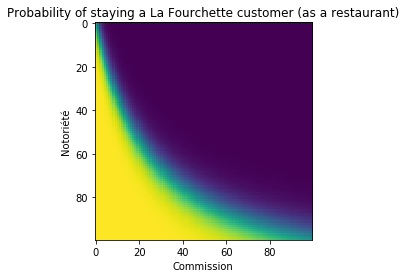

In [704]:
mat = [[max(staying_prob(x, y, C), 0) for x in np.linspace(0, 0.3, 100)] for y in np.linspace(1, 0, 100)]
mplt.imshow(mat)
mplt.title("Probability of staying a La Fourchette customer (as a restaurant)")
mplt.xlabel("Commission")
mplt.ylabel("Notoriété")

Text(0, 0.5, 'Notoriété')

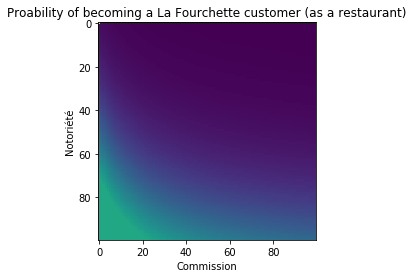

In [705]:
mat = [[max(entering_prob(x, y, C), 0) for x in np.linspace(0, 0.3, 100)] for y in np.linspace(1, 0, 100)]
mat[0][0]=1
mplt.imshow(mat)
mplt.title("Proability of becoming a La Fourchette customer (as a restaurant)")
mplt.xlabel("Commission")
mplt.ylabel("Notoriété")

In [348]:
attractiveness(0.3,1, C)

-0.10000000000000087

In [499]:
r = Restaurant(0, "n", 0, 0, "jkgvhgv", 2022)
r.generate_random_params(5)

In [500]:
notoriety = []
for i in range(1000):
    r.give_grade(np.random.choice([0,1,2,5]))
    r.update_notoriety()
    notoriety.append(r.notoriety)
    r.current_day += 1

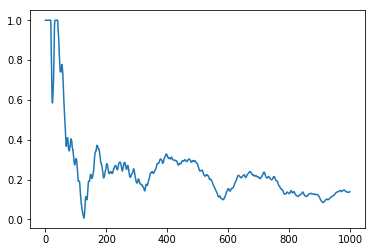

In [501]:
mplt.plot(notoriety)

In [540]:
[1, 2][-1:]

[2]

In [671]:
u = User()
u.generate_random_params()

In [672]:
prob = []
for i in range(10):
    u.give_grade(r, np.random.choice([0,1,2,3,4,5]))
    u.update_use_lf_prob()
    prob.append(u.get_lf_prob(np.random.rand()/5))
    r.current_day += 1

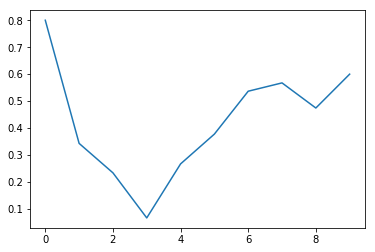

In [673]:
mplt.plot(prob)

In [675]:
users = [User() for i in range(1000)]
for user in users:
    user.generate_random_params()

In [699]:
for i in range(10):
    for u in users:
        u.give_grade(r, np.random.choice([0,1,2,3,4,5]))
        u.update_use_lf_prob()
        prob.append(u.get_lf_prob(np.random.rand()/5))

In [700]:
probs = [u.get_lf_prob() for u in users]

(array([ 17.,  31., 126., 101., 227., 235.,  93.,  77.,  71.,  22.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

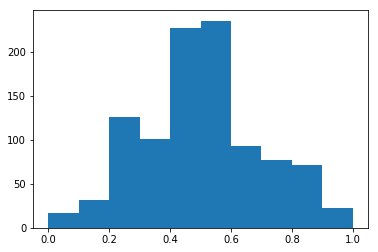

In [701]:
mplt.hist(probs, bins=10)

In [702]:
spec = np.unique([r.specialities for r in restaurants])

NameError: name 'restaurants' is not defined